In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import cv2
import sys
from skimage import io
from skimage import color
from skimage import transform
from skimage import util
import time

In [ ]:
import torch
from torch.utils import data
import torch.nn as nn
from torch.nn import init
from torch.utils.data import DataLoader
import albumentations as album 
from torch.autograd import Variable
import torchvision.models as models
import torchvision.transforms as T
from torchsummary import summary
import torch.nn.functional as F

In [ ]:
potsdam = "/content/drive/MyDrive/BTPII/Potsdam"

#### Custom Dataset

In [ ]:
class ListDataset(data.Dataset):

    def __init__(self, root, dataset, mode, crop_size, normalization='minmax', hidden_classes=None, overlap=False, use_dsm=False):

        # Initializing variables.
        self.root = root
        self.dataset = dataset
        self.mode = mode
        self.crop_size = crop_size
        self.normalization = normalization
        self.hidden_classes = hidden_classes
        self.overlap = overlap
        self.use_dsm = use_dsm
        
        self.num_classes = 6 # For Vaihingen and Potsdam.
            
        if self.hidden_classes is not None:
            self.n_classes = self.num_classes - len(hidden_classes)
        else:
            self.n_classes = self.num_classes

        # Creating list of paths.
        self.imgs = self.make_dataset()

        # Check for consistency in list.
        if len(self.imgs) == 0:

            raise (RuntimeError('Found 0 images, please check the data set'))

    def make_dataset(self):

        # Making sure the mode is correct.
        assert self.mode in ['Train', 'Test', 'Val']

        # Setting string for the mode.
        img_dir = os.path.join(self.root, self.mode, 'Images')
        msk_dir = os.path.join(self.root, self.mode, 'Masks')
        if self.use_dsm:
            dsm_dir = os.path.join(self.root, self.mode, 'NDSM')

        # if self.mode == 'Val':
        #     img_dir = os.path.join(self.root, 'Train', 'Images')
        #     msk_dir = os.path.join(self.root, 'Train', 'Masks')
        #     if self.use_dsm:
        #         dsm_dir = os.path.join(self.root, 'Train', 'NDSM')

        data_list = sorted([f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))])

        # Creating list containing image and ground truth paths.
        items = []
        if self.dataset == 'Vaihingen':
            for it in data_list:
                item = (
                    os.path.join(img_dir, it),
                    os.path.join(msk_dir, it),
                    # os.path.join(dsm_dir, it.replace('top_mosaic_09cm_area', 'dsm_09cm_matching_area').replace('.tif', '_normalized.jpg'))
                )
                items.append(item)
        elif self.dataset == 'Potsdam':
            for it in data_list:
                if self.use_dsm:
                    item = (
                        os.path.join(img_dir, it),
                        os.path.join(msk_dir, it.replace('_IRRG.tif', '_label.tif')),
                        # os.path.join(msk_dir, it.replace('_IRRG.tif', '_label_noBoundary.tif')),
                        os.path.join(dsm_dir, it.replace('top_potsdam_', 'dsm_potsdam_').replace('_IRRG.tif', '_normalized_lastools.jpg'))
                    )
                else:
                    item = (
                        os.path.join(img_dir, it),
                        os.path.join(msk_dir, it.replace('_IRRG.tif', '_label.tif')),
                        # os.path.join(msk_dir, it.replace('_IRRG.tif', '_label_noBoundary.tif')),
                        # os.path.join(dsm_dir, it.replace('top_potsdam_', 'dsm_potsdam_').replace('_IRRG.tif', '_normalized_lastools.jpg'))
                    )
                items.append(item)
        
        # Returning list.
        return items
    
    def random_crops(self, img, msk, msk_true, n_crops):
        
        img_crop_list = []
        msk_crop_list = []
        msk_true_crop_list = []
        
        rand_fliplr = np.random.random() > 0.50
        rand_flipud = np.random.random() > 0.50
        rand_rotate = np.random.random()
        
        for i in range(n_crops):
            
            rand_y = np.random.randint(msk.shape[0] - self.crop_size[0])
            rand_x = np.random.randint(msk.shape[1] - self.crop_size[1])

            img_patch = img[rand_y:(rand_y + self.crop_size[0]),
                            rand_x:(rand_x + self.crop_size[1])]
            msk_patch = msk[rand_y:(rand_y + self.crop_size[0]),
                            rand_x:(rand_x + self.crop_size[1])]
            msk_true_patch = msk_true[rand_y:(rand_y + self.crop_size[0]),
                                      rand_x:(rand_x + self.crop_size[1])]
            
            if rand_fliplr:
                img_patch = np.fliplr(img_patch)
                msk_patch = np.fliplr(msk_patch)
                msk_true_patch = np.fliplr(msk_true_patch)
            if rand_flipud:
                img_patch = np.flipud(img_patch)
                msk_patch = np.flipud(msk_patch)
                msk_true_patch = np.flipud(msk_true_patch)
            
            if rand_rotate < 0.25:
                img_patch = transform.rotate(img_patch, 270, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 270, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 270, order=0, preserve_range=True)
            elif rand_rotate < 0.50:
                img_patch = transform.rotate(img_patch, 180, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 180, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 180, order=0, preserve_range=True)
            elif rand_rotate < 0.75:
                img_patch = transform.rotate(img_patch, 90, order=1, preserve_range=True)
                msk_patch = transform.rotate(msk_patch, 90, order=0, preserve_range=True)
                msk_true_patch = transform.rotate(msk_true_patch, 90, order=0, preserve_range=True)
                
            img_patch = img_patch.astype(np.float32)
            msk_patch = msk_patch.astype(np.int64)
            msk_true_patch = msk_true_patch.astype(np.int64)
            
            img_crop_list.append(img_patch)
            msk_crop_list.append(msk_patch)
            msk_true_crop_list.append(msk_true_patch)
        
        img = np.asarray(img_crop_list)
        msk = np.asarray(msk_crop_list)
        msk_true = np.asarray(msk_true_crop_list)
        
        return img, msk, msk_true
        
    def test_crops(self, img, msk, msk_true):
        
        n_channels = 3
        if self.use_dsm:
            n_channels = 4
        if self.overlap:
            w_img = util.view_as_windows(img,
                                         (self.crop_size[0], self.crop_size[1], n_channels),
                                         (self.crop_size[0] // 2, self.crop_size[1] // 2, n_channels)).squeeze()
            w_msk = util.view_as_windows(msk,
                                         (self.crop_size[0], self.crop_size[1]),
                                         (self.crop_size[0] // 2, self.crop_size[1] // 2))
            w_msk_true = util.view_as_windows(msk_true,
                                              (self.crop_size[0], self.crop_size[1]),
                                              (self.crop_size[0] // 2, self.crop_size[1] // 2))
        else:
            w_img = util.view_as_blocks(img, (self.crop_size[0], self.crop_size[1], n_channels)).squeeze()
            w_msk = util.view_as_blocks(msk, (self.crop_size[0], self.crop_size[1]))
            w_msk_true = util.view_as_blocks(msk_true, (self.crop_size[0], self.crop_size[1]))
        
        return w_img, w_msk, w_msk_true
        
    def shift_labels(self, msk):
        
        msk_true = np.copy(msk)
        
        cont = 0
        for h_c in self.hidden_classes:
            
            msk[msk == h_c - cont] = 100
            for c in range(h_c - cont + 1, self.num_classes):
                msk[msk == c] = c - 1
                # msk_true[msk_true == c] = c - 1
            cont = cont + 1
        
        # msk_true[msk == 100] = self.num_classes - len(self.hidden_classes)
        msk[msk == 100] = self.num_classes #- len(self.hidden_classes)
        
        return msk, msk_true
    
    def mask_to_class(self, msk):
    
        msk = msk.astype(np.int64)
        new = np.zeros((msk.shape[0], msk.shape[1]), dtype=np.int64)
        
        msk = msk // 255
        msk = msk * (1, 7, 49)
        msk = msk.sum(axis=2)

        new[msk == 1 + 7 + 49] = 0 # Street.
        new[msk ==         49] = 1 # Building.
        new[msk ==     7 + 49] = 2 # Grass.
        new[msk ==     7     ] = 3 # Tree.
        new[msk == 1 + 7     ] = 4 # Car.
        new[msk == 1         ] = 5 # Surfaces.
        new[msk == 0         ] = 6 # Boundaries.

        return new
        
    def __getitem__(self, index):
        
        # Reading items from list.
        if self.use_dsm:
            img_path, msk_path, dsm_path = self.imgs[index]
        else:
            img_path, msk_path = self.imgs[index]
        
        # Reading images.
        img_raw = io.imread(img_path)
        msk_raw = io.imread(msk_path)
        if self.use_dsm:
            dsm_raw = io.imread(dsm_path)
            
        if len(img_raw.shape) == 2:
            img_raw = color.gray2rgb(img_raw)
        
        if self.use_dsm:
            img = np.full((img_raw.shape[0] + self.crop_size[0] - (img_raw.shape[0] % self.crop_size[0]),
                           img_raw.shape[1] + self.crop_size[1] - (img_raw.shape[1] % self.crop_size[1]),
                           img_raw.shape[2] + 1),
                          fill_value=0.0,
                          dtype=np.float32)
        else:
            img = np.full((img_raw.shape[0] + self.crop_size[0] - (img_raw.shape[0] % self.crop_size[0]),
                           img_raw.shape[1] + self.crop_size[1] - (img_raw.shape[1] % self.crop_size[1]),
                           img_raw.shape[2]),
                          fill_value=0.0,
                          dtype=np.float32)
        
        msk = np.full((msk_raw.shape[0] + self.crop_size[0] - (msk_raw.shape[0] % self.crop_size[0]),
                       msk_raw.shape[1] + self.crop_size[1] - (msk_raw.shape[1] % self.crop_size[1]),
                       msk_raw.shape[2]),
                      fill_value=0,
                      dtype=np.int64)
        
        img[:img_raw.shape[0], :img_raw.shape[1], :img_raw.shape[2]] = img_raw
        if self.use_dsm:
            img[:dsm_raw.shape[0], :dsm_raw.shape[1], -1] = dsm_raw
        msk[:msk_raw.shape[0], :msk_raw.shape[1]] = msk_raw
        
        msk = self.mask_to_class(msk)
        
        msk, msk_true = self.shift_labels(msk)
        
        # Normalization.
        img = (img / 255) - 0.5
        
        if self.mode == 'Train':
            
            img, msk, msk_true = self.random_crops(img, msk, msk_true, 3)
            
            img = np.transpose(img, (0, 3, 1, 2))
        
        elif self.mode == 'Val':
            
            img, msk, msk_true = self.test_crops(img, msk, msk_true)
            
            img = np.transpose(img, (0, 1, 4, 2, 3))
            msk = np.transpose(msk, (0, 1, 2, 3))
            msk_true = np.transpose(msk_true, (0, 1, 2, 3))
        
        elif self.mode == 'Test':
            
            img, msk, msk_true = self.test_crops(img, msk, msk_true)
            
            img = np.transpose(img, (0, 1, 4, 2, 3))
            msk = np.transpose(msk, (0, 1, 2, 3))
            msk_true = np.transpose(msk_true, (0, 1, 2, 3))
        
        msk[msk == self.num_classes + 1] = self.num_classes
        msk_true[msk_true == self.num_classes + 1] = self.num_classes

        # Splitting path.
        spl = img_path.split('/')

        # Turning to tensors.
        img = torch.from_numpy(img)
        msk = torch.from_numpy(msk)
        msk_true = torch.from_numpy(msk_true)

        # Returning to iterator.
        return img, msk, msk_true, spl[-1]

    def __len__(self):

        return len(self.imgs)

#### FCN Models

In [ ]:
class FCNWideResNet50(nn.Module):
    
    def __init__(self, input_channels, num_classes, pretrained=True, skip=True, hidden_classes=None):

        super(FCNWideResNet50, self).__init__()

        self.skip = skip
        
        # ResNet-50 with Skip Connections (adapted from FCN-8s).
        wideresnet = models.wide_resnet50_2(pretrained=pretrained, progress=False)

        if pretrained:
            self.init = nn.Sequential(
                wideresnet.conv1,
                wideresnet.bn1,
                wideresnet.relu,
                wideresnet.maxpool
            )
        else:
            self.init = nn.Sequential(
                nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
                wideresnet.bn1,
                wideresnet.relu,
                wideresnet.maxpool
            )
        self.layer1 = wideresnet.layer1
        self.layer2 = wideresnet.layer2
        self.layer3 = wideresnet.layer3
        self.layer4 = wideresnet.layer4
        
        if self.skip:
            
            if hidden_classes is None:
                self.classifier1 = nn.Sequential(
                    nn.Conv2d(2048 + 256, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Dropout2d(0.5),
                )
                self.final = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
            else:
                self.classifier1 = nn.Sequential(
                    nn.Conv2d(2048 + 256, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Dropout2d(0.5),
                )
                self.final = nn.Conv2d(64, num_classes - len(hidden_classes), kernel_size=3, padding=1)
                
        else:

            if hidden_classes is None:
                self.classifier1 = nn.Sequential(
                    nn.Conv2d(2048, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Dropout2d(0.5),
                )
                self.final = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
            else:
                self.classifier1 = nn.Sequential(
                    nn.Conv2d(2048, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Dropout2d(0.5),
                )
                self.final = nn.Conv2d(64, num_classes - len(hidden_classes), kernel_size=3, padding=1)
        
        if not pretrained:
            initialize_weights(self)
        else:
            initialize_weights(self.classifier1)
            initialize_weights(self.final)

    def forward(self, x, feat=False):
        
        if self.skip:
            
            # Forward on FCN with Skip Connections.
            fv_init = self.init(x)
            fv1 = self.layer1(fv_init)
            fv2 = self.layer2(fv1)
            fv3 = self.layer3(fv2)
            fv4 = self.layer4(fv3)
            
            fv_final = torch.cat([F.upsample(fv1, x.size()[2:], mode='bilinear'),
                                  F.upsample(fv4, x.size()[2:], mode='bilinear')], 1)
            
        else:
            
            # Forward on FCN without Skip Connections.
            fv_init = self.init(x)
            fv1 = self.layer1(fv_init)
            fv2 = self.layer2(fv1)
            fv3 = self.layer3(fv2)
            fv4 = self.layer4(fv3)
            
            fv_final = F.upsample(fv4, x.size()[2:], mode='bilinear')
            
        classif1 = self.classifier1(fv_final)
        output = self.final(classif1)
        
        if feat:
            return (output, classif1, F.upsample(fv2, x.size()[2:], mode='bilinear'))
        else:
            return output

In [ ]:
class FCNDenseNet121(nn.Module):
    
    def __init__(self, input_channels, num_classes, pretrained=True, skip=True, hidden_classes=None):

        super(FCNDenseNet121, self).__init__()

        self.skip = skip
        
        # DenseNet with Skip Connections (adapted from FCN-8s).
        densenet = models.densenet121(pretrained=pretrained, progress=False)

        if pretrained:
            self.init = densenet.features[:4]
        else:
            self.init = nn.Sequential(
                nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )
        self.dense1 = densenet.features[4:6]
        self.dense2 = densenet.features[6:8]
        self.dense3 = densenet.features[8:10]
        self.dense4 = densenet.features[10:12]
        
        if self.skip:
            
            if hidden_classes is None:
                self.classifier1 = nn.Sequential(
                    nn.Conv2d(1024 + 256, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Dropout2d(0.5),
                )
                self.final = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
            else:
                self.classifier1 = nn.Sequential(
                    nn.Conv2d(1024 + 256, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Dropout2d(0.5),
                )
                self.final = nn.Conv2d(64, num_classes - len(hidden_classes), kernel_size=3, padding=1)
                
        else:

            if hidden_classes is None:
                self.classifier1 = nn.Sequential(
                    nn.Conv2d(1024, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Dropout2d(0.5),
                )
                self.final = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
            else:
                self.classifier1 = nn.Sequential(
                    nn.Conv2d(1024, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Dropout2d(0.5),
                )
                self.final = nn.Conv2d(64, num_classes - len(hidden_classes), kernel_size=3, padding=1)
        
        if not pretrained:
            initialize_weights(self)
        else:
            initialize_weights(self.classifier1)
            initialize_weights(self.final)
            

    def forward(self, x, feat=False):
        
        if self.skip:
            
            # Forward on FCN with Skip Connections.
            fv_init = self.init(x)
            fv1 = self.dense1(fv_init)
            fv2 = self.dense2(fv1)
            fv3 = self.dense3(fv2)
            fv4 = self.dense4(fv3)

            fv_final = torch.cat([F.upsample(fv2, x.size()[2:], mode='bilinear'),
                                  F.upsample(fv4, x.size()[2:], mode='bilinear')], 1)

        else:

            # Forward on FCN without Skip Connections.
            fv_init = self.init(x)
            fv1 = self.dense1(fv_init)
            fv2 = self.dense2(fv1)
            fv3 = self.dense3(fv2)
            fv4 = self.dense4(fv3)

            fv_final = F.upsample(fv4, x.size()[2:], mode='bilinear')

        classif1 = self.classifier1(fv_final)
        output = self.final(classif1)
        
        if feat:
            return (output, classif1, F.upsample(fv2, x.size()[2:], mode='bilinear'))

        else:
            return output

#### Misc

In [ ]:
from math import ceil

def check_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)


def initialize_weights(*models):
    for model in models:
        for module in model.modules():
#             if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


def get_upsampling_weight(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()



In [ ]:
class unknownClassifier(nn.Module):
    
    def __init__(self, in_channels):
        super(unknownClassifier, self).__init__()
        # output classes in, out
        self.dimr = nn.Conv2d(in_channels, 2, kernel_size=1)
    
    def forward(self, x):
        out = self.dimr(x)
        return out


In [ ]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True, ignore_index=-1):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss(weight, ignore_index=ignore_index, reduction='mean')

    def forward(self, inputs, targets):
    	#print(inputs.shape)
        return self.nll_loss(F.log_softmax(inputs, dim = 1), targets)


In [ ]:
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
#             if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


#### Train function

In [ ]:
def train(train_loader, net, criterion, optimizer, epoch, num_known_classes, num_unknown_classes, hidden, args):

    # Setting network for training mode.
    net.train()

    # Average Meter for batch loss.
    train_loss = list()

    # Iterating over batches.
    for i, data in enumerate(train_loader):
        
        # Obtaining images, labels and paths for batch.
        inps, labs, true, img_name = data
        
        # Casting tensors to cuda.
        inps, labs, true = inps.to(DEVICE), labs.to(DEVICE), true.to(DEVICE)
        
        # Casting to cuda variables.
        inps = Variable(inps).to(DEVICE)
        labs = Variable(labs).to(DEVICE)
        true = Variable(true).to(DEVICE)
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()
        
        # Forwarding.
        outs = net(inps)
        soft_outs = F.softmax(outs, dim=1)
        
        # Obtaining predictions.
        prds = soft_outs.data.max(1)[1]
        
        # Computing loss.
        loss = criterion(outs, labs)
        
        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Appending images for epoch loss calculation.
        # prds = prds.squeeze_(1).squeeze_(0).cpu().numpy()
        
        # inps_np = inps.detach().squeeze(0).cpu().numpy()
        # labs_np = labs.detach().squeeze(0).cpu().numpy()
        # true_np = true.detach().squeeze(0).cpu().numpy()
        
        # Updating loss meter.
        train_loss.append(loss.data.item())
        
        # Printing.
        if (i + 1) % print_freq == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f]' % (epoch, i + 1, len(train_loader), np.asarray(train_loss).mean()))
            sys.stdout.flush()
    
    sys.stdout.flush()

#### Test function

In [ ]:
def test(test_loader, net, criterion, optimizer, epoch, num_known_classes, num_unknown_classes, hidden, args, save_images, save_model):
    
    # Setting network for evaluation mode.
    net.eval()
    
    with torch.no_grad():
        
        # Creating output directory.
        check_mkdir(os.path.join(outp_path, exp_name, 'epoch_' + str(epoch)))
        
        # Iterating over batches.
        for i, data in enumerate(test_loader):
            
            print('Test Batch %d/%d' % (i + 1, len(test_loader)))
            sys.stdout.flush()
            
            # Obtaining images, labels and paths for batch.
            inps_batch, labs_batch, true_batch, img_name = data
            
            inps_batch = inps_batch.squeeze()
            labs_batch = labs_batch.squeeze()
            true_batch = true_batch.squeeze()
            
            # Iterating over patches inside batch.
            for j in range(inps_batch.size(0)): #inps_batch.size(0)
                
                print('    Test MiniBatch %d/%d' % (j + 1, inps_batch.size(0)))
                sys.stdout.flush()
                
                tic = time.time()
                
                for k in range(inps_batch.size(1)): #inps_batch.size(1)
                    
                    inps = inps_batch[j, k].unsqueeze(0)
                    labs = labs_batch[j, k].unsqueeze(0)
                    true = true_batch[j, k].unsqueeze(0)
                    
                    # Casting tensors to cuda.
                    inps, labs, true = inps.to(DEVICE), labs.to(DEVICE), true.to(DEVICE)
                    
                    # Casting to cuda variables.
                    inps = Variable(inps).to(DEVICE)
                    labs = Variable(labs).to(DEVICE)
                    true = Variable(true).to(DEVICE)
                    
                    # Forwarding.
                    if conv_name == 'fcnwideresnet50':
                        outs, classif1, fv2 = net(inps, feat=True)
                    elif conv_name == 'fcndensenet121':
                        outs, classif1, fv2 = net(inps, feat=True)
                    
                    # Computing probabilities.
                    soft_outs = F.softmax(outs, dim=1)
                    
                    # Obtaining prior predictions.
                    prds = soft_outs.data.max(1)[1]
                    
                    # Obtaining posterior predictions.
                    # if conv_name == 'fcnwideresnet50':
                    #     feat_flat = torch.cat([outs, classif1, fv2], 1)
                    # elif conv_name == 'fcndensenet121':
                    #     feat_flat = torch.cat([outs, classif1, fv2], 1)
                        
                    # feat_flat = feat_flat.permute(0, 2, 3, 1).contiguous().view(feat_flat.size(0) * feat_flat.size(2) * feat_flat.size(3), feat_flat.size(1)).cpu().numpy()
                    # prds_flat = prds.cpu().numpy().ravel()
                    # true_flat = true.cpu().numpy().ravel()
                    
                    # # Appending images for epoch loss calculation.
                    inps_np = inps.detach().squeeze(0).cpu().numpy()
                    labs_np = labs.detach().squeeze(0).cpu().numpy()
                    true_np = true.detach().squeeze(0).cpu().numpy()
                    
                    # Saving predictions.
                    if (save_images):
                        
                        # imag_path = os.path.join(outp_path, exp_name, 'epoch_' + str(epoch), img_name[0].replace('.tif', '_img_' + str(j) + '_' + str(k) + '.png'))
                        # mask_path = os.path.join(outp_path, exp_name, 'epoch_' + str(epoch), img_name[0].replace('.tif', '_msk_' + str(j) + '_' + str(k) + '.png'))
                        # true_path = os.path.join(outp_path, exp_name, 'epoch_' + str(epoch), img_name[0].replace('.tif', '_tru_' + str(j) + '_' + str(k) + '.png'))
                        pred_path = os.path.join(outp_path, exp_name, 'epoch_' + str(epoch), img_name[0].replace('.tif', '_prd_' + str(j) + '_' + str(k) + '.png'))
                        
                        plt.figure(figsize=(16, 6))
                        plt.subplot(141)
                        plt.title("Image")
                        plt.imshow(np.transpose((inps_np[0:3,:,:] + 0.5), (1, 2, 0)))
                        plt.subplot(142)
                        plt.title("Mask")
                        plt.imshow(labs_np, cmap=lab_cmap_1)
                        plt.clim(0, 5)
                        plt.subplot(143)
                        plt.title("True Mask")
                        plt.imshow(true_np, cmap=lab_cmap)
                        plt.clim(0, 5)
                        plt.subplot(144)
                        plt.title("Prediction")
                        plt.imshow(prds.cpu().squeeze().numpy(), cmap=lab_cmap_1)
                        plt.clim(0, 5)
                        plt.savefig(pred_path)
                        plt.clf()
                        plt.close()
                        # io.imsave(imag_path, np.transpose(((inps_np[0:3,:,:] + 0.5)*255).astype(np.uint8), (1, 2, 0)))
                        # io.imsave(mask_path, util.img_as_ubyte(labs_np.astype(np.uint8)))
                        # io.imsave(true_path, util.img_as_ubyte(true_np.astype(np.uint8)))
                        # io.imsave(pred_path, util.img_as_ubyte(prds.cpu().squeeze().numpy().astype(np.uint8)))

                toc = time.time()
                print('        Elapsed Time: %.2f' % (toc - tic))
        
        sys.stdout.flush()
        
        if save_model:
            
            torch.save(net.state_dict(), os.path.join(ckpt_path, exp_name, 'model_' + str(epoch) + '.pth'))
            torch.save(optimizer.state_dict(), os.path.join(ckpt_path, exp_name, 'opt_' + str(epoch) + '.pth'))

#### Functioning

In [ ]:
# potsdam
lr = 1e-3
weight_decay = 5e-6
momentum = 0.9
batch_size = 1
# num_workers = 8
print_freq = 1
w_size = 224
h_size = 224
input_channels = 4
num_classes = 6
epoch_num = 600
test_freq = 600
save_freq = 600
num_workers = 1
conv_name = 'fcndensenet121'
args = f'lr:{lr}, weight_decay:{weight_decay} momentum:{momentum} batch_size:{batch_size} num_workers:{num_workers} print_freq:{print_freq} \
        w_size:{w_size} h_size:{h_size} input_channels:{input_channels} num_classes:{num_classes} epoch_num:{epoch_num} test_freq:{test_freq} \
        save_freq:{save_freq} conv_name:{conv_name}'

In [ ]:
HiddenClasses = [1]
num_known_classes = num_classes - len(HiddenClasses)
num_unknown_classes = len(HiddenClasses)
weights = [1.0 for i in range(num_known_classes)]
weights = torch.FloatTensor(weights)
DEVICE = 'cuda'

In [ ]:
# hidden class Nil
traindata = ListDataset(potsdam, 'Potsdam', 'Train', (h_size, w_size), hidden_classes=HiddenClasses, overlap=False, use_dsm=True)
trainloader = DataLoader(traindata, batch_size=None, num_workers=num_workers, shuffle=True)

valdata = ListDataset(potsdam, 'Potsdam', 'Val', (h_size, w_size), hidden_classes=HiddenClasses, overlap=True, use_dsm=True)
valloader = DataLoader(valdata, batch_size=1, num_workers=0, shuffle=True)

testdata = ListDataset(potsdam, 'Potsdam', 'Test', (h_size, w_size), hidden_classes=HiddenClasses, overlap=True, use_dsm=True)
testloader = DataLoader(testdata, batch_size=1, num_workers=0, shuffle=True)

In [ ]:
def convert(msk):
    msk = msk.astype(np.int64)
    new = np.zeros((msk.shape[0], msk.shape[1]), dtype=np.int64)
    
    msk = msk // 255
    msk = msk * (1, 7, 49)
    msk = msk.sum(axis=2)

    new[msk == 1 + 7 + 49] = 0 # Street.
    new[msk ==         49] = 1 # Building.
    new[msk ==     7 + 4.max(1)[1]9] = 2 # Grass.
    new[msk ==     7     ] = 3 # Tree.
    new[msk == 1 + 7     ] = 4 # Car.
    new[msk == 1         ] = 5 # Surfaces.
    new[msk == 0         ] = 6 # Boundaries.

    return new

In [ ]:
from matplotlib import colors
'''
Vaihingen/Potsdam classes:
    0 = Street
    1 = Building
    2 = Grass
    3 = Tree
    4 = Car
    5 = Surfaces
    6 = Boundaries
'''
# no hidden class cmap
cmap_list = [
    (1.0, 1.0, 1.0, 1.0), # street. 
    (0.0, 0.0, 1.0, 1.0), # Building
    (0.0, 1.0, 1.0, 1.0), # Grass.
    (0.0, 1.0, 0.0, 1.0), # Tree.
    (1.0, 1.0, 0.0, 1.0), # Car.
    (1.0, 0.0, 0.0, 1.0),  # surfaces
    # (0.0, 0.0, 0.0, 1.0), # Boundaries (if present).
]
lab_cmap = colors.ListedColormap(cmap_list)

In [ ]:
cmap_list_1 = [
    (1.0, 1.0, 1.0, 1.0), # street.
    (0.0, 1.0, 1.0, 1.0), # Grass.
    (0.0, 1.0, 0.0, 1.0), # Tree.
    (1.0, 1.0, 0.0, 1.0), # Car.
    (1.0, 0.0, 0.0, 1.0),  # surfaces       
    (0.0, 0.0, 1.0, 1.0), # Building  
    # (0.0, 0.0, 0.0, 1.0), # Boundaries (if present).
]
lab_cmap_1 = colors.ListedColormap(cmap_list_1)

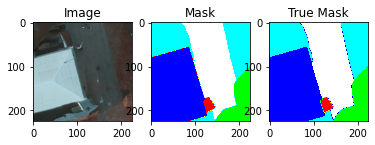

In [ ]:
img, msk, msk_true, spl = valdata[0]
a = 0
b = 29#np.random.randint(30)
plt.subplot(131)
plt.title("Image")
plt.imshow(img[a, b, :3, :, :].permute(1, 2, 0)+0.5)
plt.subplot(132)
plt.title("Mask")
plt.imshow(msk[a, b, :, :], cmap=lab_cmap_1)
plt.clim(0, 5)
plt.subplot(133)
plt.title("True Mask")
plt.imshow(msk_true[a, b, :, :], cmap=lab_cmap)
plt.clim(0, 5)
# plt.subplot(144)
# plt.title("Prediction")
# plt.imshow(prds.cpu().squeeze().numpy(), cmap=lab_cmap_1)
plt.show()

In [ ]:
print(msk[a, b, 200, 50], msk_true[a, b, 200, 50])

tensor(6) tensor(1)


In [ ]:
outp_path = '/content/drive/MyDrive/BTPII/outputs'
ckpt_path = '/content/drive/MyDrive/BTPII/checkpoints'
exp_name = 'hc_0_exp2'
best_record = {'epoch': 0, 'lr': 1e-4, 'val_loss': 1e10, 'acc': 0, 'acc_cls': 0, 'iou': 0}

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
# model = FCNWideResNet50(input_channels, num_classes, pretrained=False, skip=True, hidden_classes=HiddenClasses).to(DEVICE)
model = FCNDenseNet121(input_channels, num_classes, pretrained=False, skip=True, hidden_classes=HiddenClasses).to(DEVICE)
criterion = CrossEntropyLoss2d(weight=weights, size_average=False, ignore_index=num_classes).to(DEVICE)
# criterion = nn.CrossEntropyLoss(weight=weights, size_average=False, ignore_index=num_classes).to(DEVICE)
optimizer = torch.optim.Adam([param for name, param in model.named_parameters() if name[-4:] == 'bias'], lr=lr, weight_decay=weight_decay, betas=(momentum, 0.99))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epoch_num//3, 0.2)

check_mkdir(ckpt_path)
check_mkdir(os.path.join(ckpt_path, exp_name))
check_mkdir(outp_path)
check_mkdir(os.path.join(outp_path, exp_name))

In [ ]:
# model.load_state_dict(torch.load(os.path.join(ckpt_path, exp_name, 'model_33.pth')))
# model.load_state_dict(torch.load(os.path.join(potsdam, 'model_600.pth')))
# model.eval()

In [ ]:
import datetime

In [ ]:
from torch.backends import cudnn
cudnn.benchmark = True

In [ ]:
curr_epoch = 1
open(os.path.join(ckpt_path, exp_name, str(datetime.datetime.now()) + '.txt'), 'w').write(args + '\n\n')

for epoch in range(curr_epoch, epoch_num + 1):

    # Training function.
    train(trainloader, model, criterion, optimizer, epoch, num_known_classes, num_unknown_classes, HiddenClasses, {})

    if epoch % test_freq == 0:
            
        torch.save(model.state_dict(), os.path.join(ckpt_path, exp_name, 'model_' + str(epoch) + '.pth'))
        torch.save(optimizer.state_dict(), os.path.join(ckpt_path, exp_name, 'opt_' + str(epoch) + '.pth'))
            
            # Computing test.
        test(valloader, model, criterion, optimizer, epoch, num_known_classes, num_unknown_classes, HiddenClasses, {}, True, True) #epoch % args['save_freq'] == 0)
        
    scheduler.step()        
    print('Exiting...')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[epoch 1], [iter 1 / 25], [train loss 2.38477]
[epoch 1], [iter 2 / 25], [train loss 2.04557]
[epoch 1], [iter 3 / 25], [train loss 1.87757]
[epoch 1], [iter 4 / 25], [train loss 1.95570]
[epoch 1], [iter 5 / 25], [train loss 1.98510]
[epoch 1], [iter 6 / 25], [train loss 1.92288]
[epoch 1], [iter 7 / 25], [train loss 1.93058]
[epoch 1], [iter 8 / 25], [train loss 2.03451]
[epoch 1], [iter 9 / 25], [train loss 2.06970]
[epoch 1], [iter 10 / 25], [train loss 2.08117]
[epoch 1], [iter 11 / 25], [train loss 2.08806]
[epoch 1], [iter 12 / 25], [train loss 2.05087]
[epoch 1], [iter 13 / 25], [train loss 2.04209]
[epoch 1], [iter 14 / 25], [train loss 2.03332]
[epoch 1], [iter 15 / 25], [train loss 2.01781]
[epoch 1], [iter 16 / 25], [train loss 2.02682]
[epoch 1], [iter 17 / 25], [train loss 2.04809]
[epoch 1], [iter 18 / 25], [train loss 2.05321]
[epoch 1], [iter 19 / 25], [train loss 2.08267]
[epoch 1], [iter 20 / 25], [train loss 2.08603]
[epoch 1], [iter 21 / 25], [train loss 2.08550]
[

In [ ]:
torch.save(model.state_dict(), os.path.join(ckpt_path, exp_name, 'model_' + str(epoch) + '.pth'))
torch.save(optimizer.state_dict(), os.path.join(ckpt_path, exp_name, 'opt_' + str(epoch) + '.pth'))

In [ ]:
test(valloader, model, criterion, optimizer, epoch, num_known_classes, num_unknown_classes, HiddenClasses, {}, True, False)

Test Batch 1/6
    Test MiniBatch 1/53


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


        Elapsed Time: 41.99
    Test MiniBatch 2/53
        Elapsed Time: 42.19
    Test MiniBatch 3/53
        Elapsed Time: 41.91
    Test MiniBatch 4/53
        Elapsed Time: 41.92
    Test MiniBatch 5/53
        Elapsed Time: 42.33
    Test MiniBatch 6/53
        Elapsed Time: 42.44
    Test MiniBatch 7/53
        Elapsed Time: 42.69
    Test MiniBatch 8/53
        Elapsed Time: 42.55
    Test MiniBatch 9/53
        Elapsed Time: 42.77
    Test MiniBatch 10/53
        Elapsed Time: 42.84
    Test MiniBatch 11/53
        Elapsed Time: 42.44
    Test MiniBatch 12/53
        Elapsed Time: 42.41
    Test MiniBatch 13/53
        Elapsed Time: 42.67
    Test MiniBatch 14/53
        Elapsed Time: 42.72
    Test MiniBatch 15/53
        Elapsed Time: 42.51
    Test MiniBatch 16/53
        Elapsed Time: 42.94
    Test MiniBatch 17/53
        Elapsed Time: 42.53
    Test MiniBatch 18/53
        Elapsed Time: 42.84
    Test MiniBatch 19/53
        Elapsed Time: 43.06
    Test MiniBatch 20/53
 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-f529038322fe>", line 1, in <module>
    test(valloader, model, criterion, optimizer, epoch, num_known_classes, num_unknown_classes, HiddenClasses, {}, True, False)
  File "<ipython-input-12-498cb0f3cefe>", line 81, in test
    plt.figure(figsize=(16, 6))
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py", line 546, in figure
    **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/backend_bases.py", line 3357, in new_figure_manager
    fig = fig_cls(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/figure.py", line 353, in __init__
    self.dpi_scale_trans = Affine2D().scale(dpi)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py", line 2002, in scale
    self.invalidate()
  File "/usr/local/

KeyboardInterrupt: ignored